In [1]:
import scanpy as sc 
import metashells as ms
from metashells.simulation import create_simulated_adata

In [2]:
adata_with_labels_file = '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/scANVI_v3.h5ad'
adata = sc.read_h5ad(adata_with_labels_file)

/ocean/projects/cis240075p/asachan/.conda/envs/metasheller-py311/lib/python3.11/site-packages/anndata/_core/anndata.py:1796: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
adata

AnnData object with n_obs × n_vars = 87916 × 3000
    obs: 'sample_id', 'cell_type', 'condition', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_mt_cb', 'log1p_total_counts_mt_cb', 'pct_counts_mt_cb', 'total_counts_ribo_cb', 'log1p_total_counts_ribo_cb', 'pct_counts_ribo_cb', 'total_counts_hb_cb', 'log1p_total_counts_hb_cb', 'pct_counts_hb_cb', 'n_genes', 'sex', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'hb', 'ribo', 'mt', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'C_scANVI_colors', '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'cell_type_colo

In [4]:
adata.X = adata.layers['counts']
adata.X.min(), adata.X.max()

(np.float64(0.0), np.float64(2359.0))

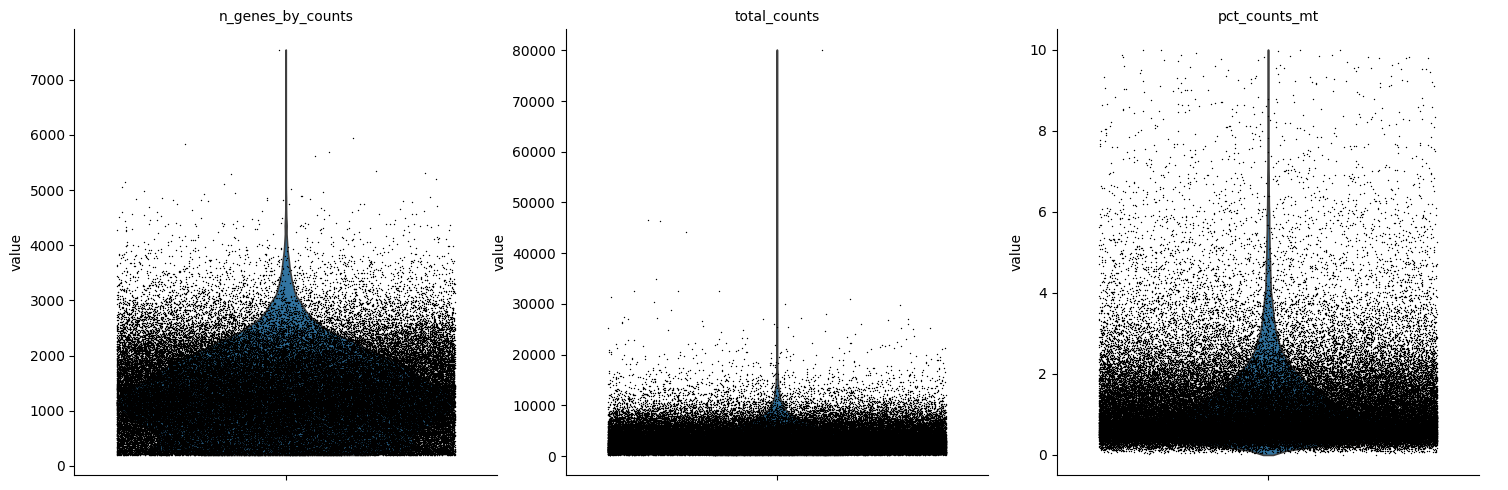

In [5]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)


In [6]:
# Filter out cells with high mitochondrial gene percentage
adata = adata[adata.obs['pct_counts_mt'] < 5]
adata

View of AnnData object with n_obs × n_vars = 86672 × 3000
    obs: 'sample_id', 'cell_type', 'condition', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_mt_cb', 'log1p_total_counts_mt_cb', 'pct_counts_mt_cb', 'total_counts_ribo_cb', 'log1p_total_counts_ribo_cb', 'pct_counts_ribo_cb', 'total_counts_hb_cb', 'log1p_total_counts_hb_cb', 'pct_counts_hb_cb', 'n_genes', 'sex', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'hb', 'ribo', 'mt', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'C_scANVI_colors', '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'cell_t

### Pre-proc data

In [7]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

/ocean/projects/cis240075p/asachan/.conda/envs/metasheller-py311/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/ocean/projects/cis240075p/asachan/.conda/envs/metasheller-py311/lib/python3.11/site-packages/anndata/_core/anndata.py:1796: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [8]:
adata.X.min(), adata.X.max()

(np.float64(0.0), np.float64(8.653730285872221))

In [9]:
sc.tl.pca(adata, n_comps=50)
sc.pp.neighbors(adata, use_rep='X_pca', n_pcs=30)

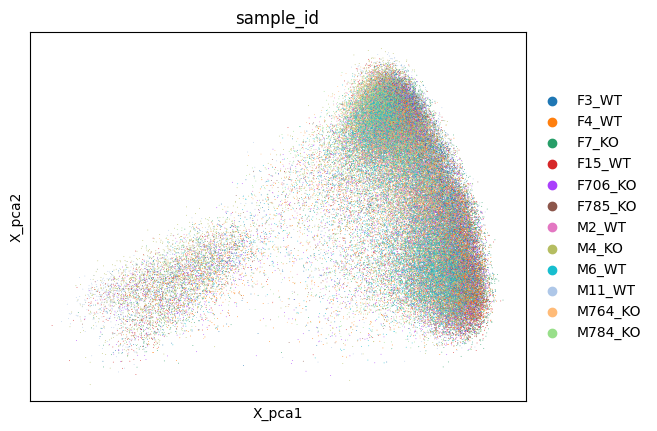

In [10]:
sc.pl.embedding(adata, basis='X_pca', color=['sample_id'])

In [11]:
sc.tl.umap(adata)

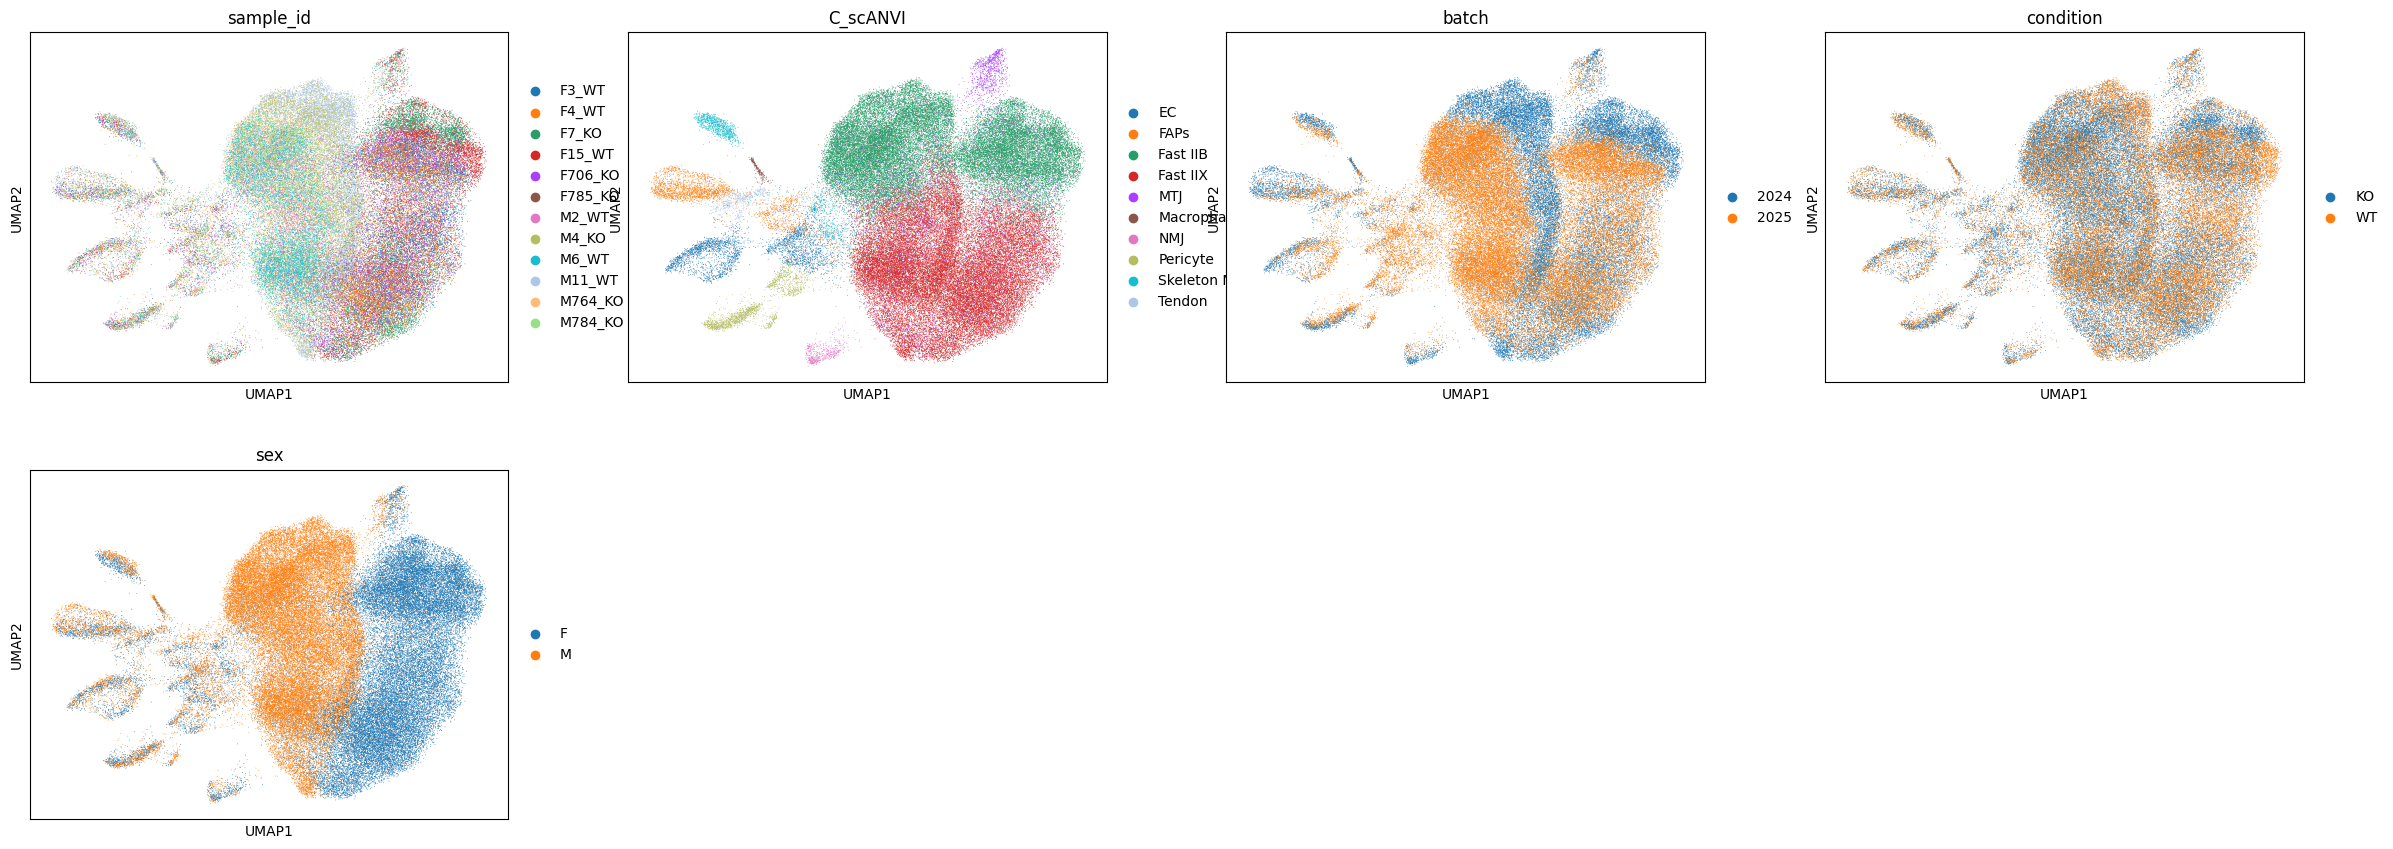

In [12]:
sc.pl.umap(adata, color=['sample_id', 'C_scANVI', 'batch', 'condition', 'sex'])

# Harmony to correct for batch effect

In [13]:
# Stronger correction with optimized parameters
sc.external.pp.harmony_integrate(
    adata, 
    key='batch',
    theta=4,        # Increase from default (2) for stronger correction
    lamb=1,         # Add regularization
    sigma=0.1,      # Decrease bandwidth
    max_iter_harmony=100,  # More iterations
    random_state=42
)

2025-12-08 14:41:55,019 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-12-08 14:42:01,598 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-12-08 14:42:02,106 - harmonypy - INFO - Iteration 1 of 100
2025-12-08 14:42:25,921 - harmonypy - INFO - Iteration 2 of 100
2025-12-08 14:42:48,319 - harmonypy - INFO - Iteration 3 of 100
2025-12-08 14:42:59,725 - harmonypy - INFO - Iteration 4 of 100
2025-12-08 14:43:10,062 - harmonypy - INFO - Iteration 5 of 100
2025-12-08 14:43:19,209 - harmonypy - INFO - Iteration 6 of 100
2025-12-08 14:43:33,948 - harmonypy - INFO - Converged after 6 iterations


In [14]:
sc.pp.neighbors(adata, use_rep='X_pca_harmony', n_pcs=30)
sc.tl.umap(adata)

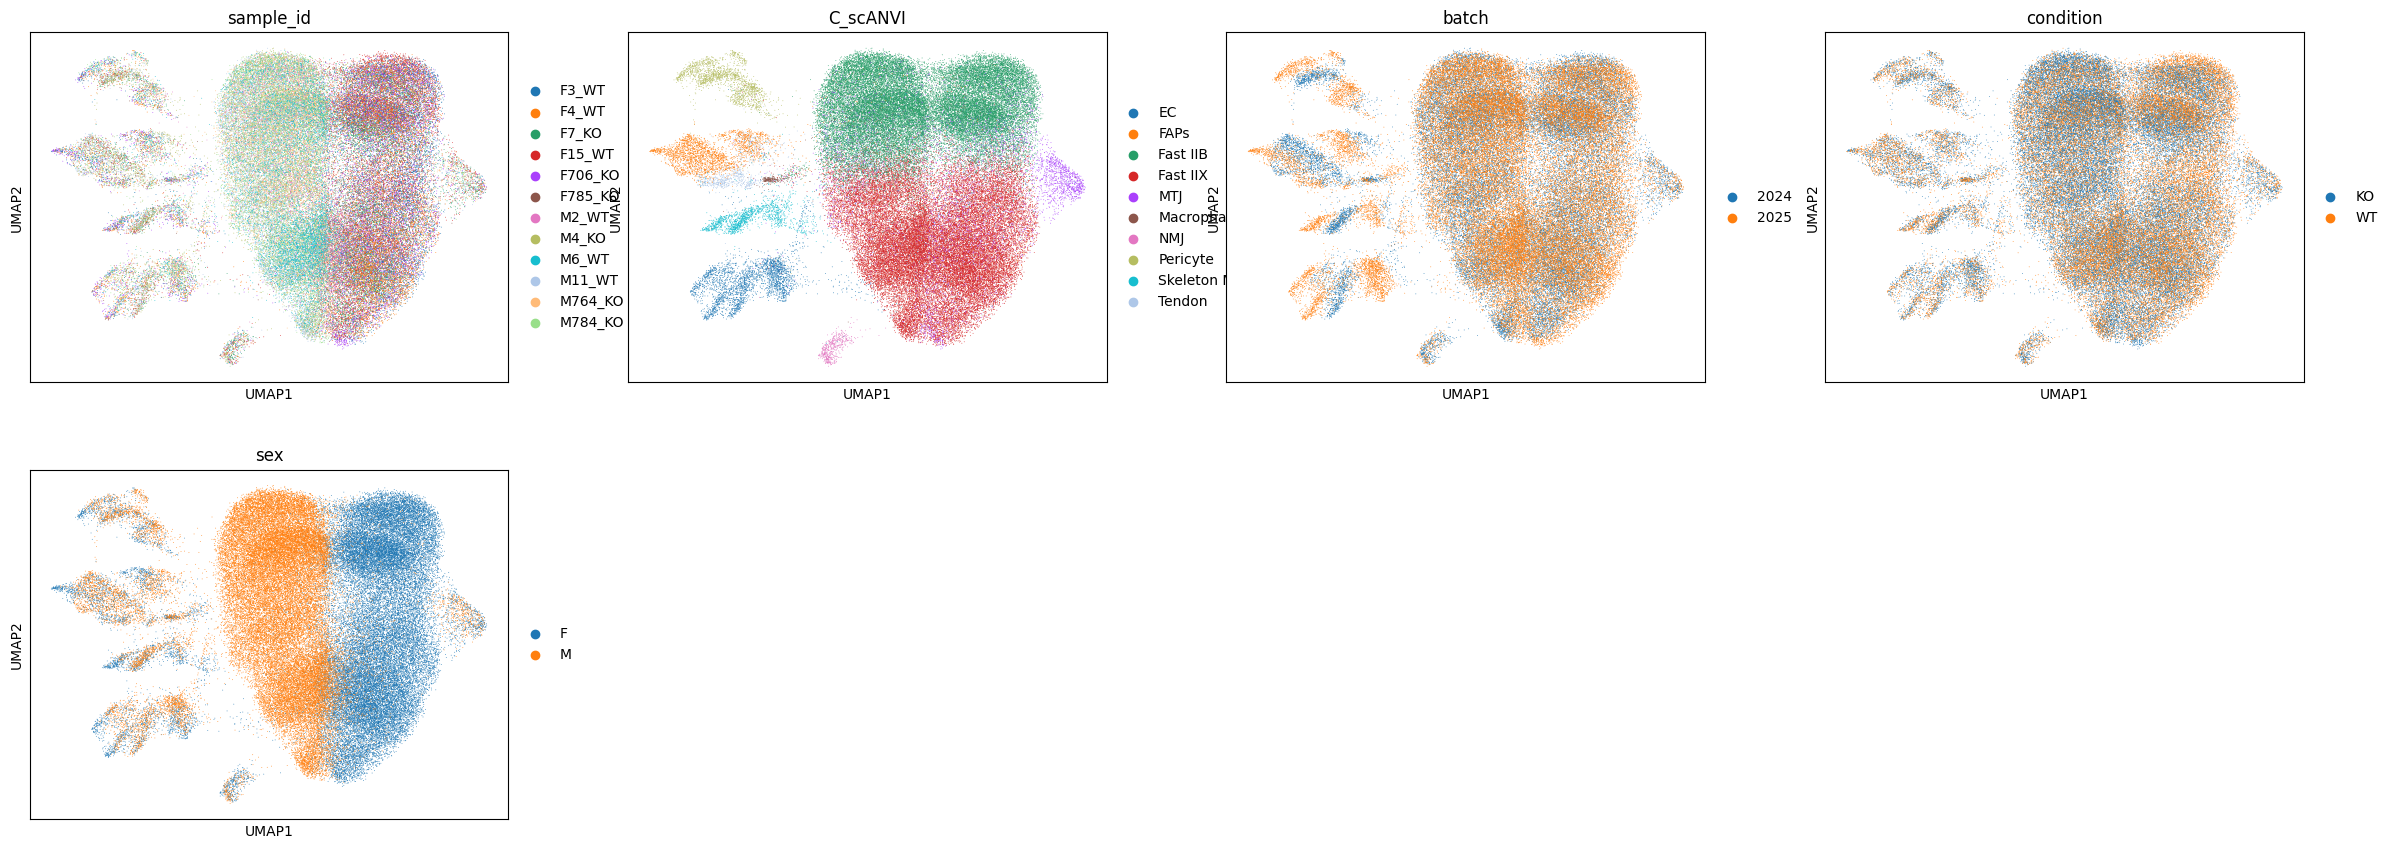

In [15]:
sc.pl.umap(adata, color=['sample_id', 'C_scANVI', 'batch', 'condition', 'sex'])

In [16]:
# save the adata object
adata.write_h5ad('/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/adata_harmony_v2.h5ad')

# Run SeaCells

In [4]:
adata = sc.read_h5ad('/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/adata_harmony_v2.h5ad')
adata_subset = adata[adata.obs['C_scANVI'].isin(['Fast IIB', 'Fast IIX'])]
adata_subset = adata_subset[adata_subset.obs['sex'] == 'F']
adata_subset

/ocean/projects/cis240075p/asachan/.conda/envs/metasheller-py311/lib/python3.11/site-packages/anndata/_core/anndata.py:1796: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


View of AnnData object with n_obs × n_vars = 33756 × 3000
    obs: 'sample_id', 'cell_type', 'condition', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_mt_cb', 'log1p_total_counts_mt_cb', 'pct_counts_mt_cb', 'total_counts_ribo_cb', 'log1p_total_counts_ribo_cb', 'pct_counts_ribo_cb', 'total_counts_hb_cb', 'log1p_total_counts_hb_cb', 'pct_counts_hb_cb', 'n_genes', 'sex', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'hb', 'ribo', 'mt', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'dispersions', 'dispersions_norm'
    uns: 'C_scANVI_colors', '_scvi_manager_uuid', '_

In [8]:
import os 

results_dir = '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/analysis/meta_cell_fast2b_2x'
os.makedirs(results_dir, exist_ok=True)

In [25]:
adata_subset.obsm['X_pca'] = adata_subset.obsm['X_pca_harmony']

/tmp/ipykernel_4391/1920269510.py:1: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata_subset.obsm['X_pca'] = adata_subset.obsm['X_pca_harmony']


In [26]:
from metashells.seashells import SeaShells 

conch = SeaShells(
    adata_full = adata_subset, 
    results_dir = results_dir,
    cells_per_metacell = 75, # recommended is 75 but can go as low as ~20 if really needed
    sample_col = 'sample_id'
)
conch.run()

/ocean/projects/cis240075p/asachan/.conda/envs/metasheller-py311/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:384: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = x_pca


Welcome to SEACells!
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/7815 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/7815 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/7815 [00:00<?, ?it/s]

Constructing CSR matrix...
Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Done.
Sampling waypoints ...
Done.
Selecting 91 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████| 23/23 [00:00<00:00, 75.72it/s]


Selecting 13 cells from greedy initialization.
Randomly initialized A matrix.
Setting convergence threshold at 0.00164
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Converged after 28 iterations.


# Prep adata from metacells

In [5]:
adata.X.min(), adata.X.max()

(np.float64(0.0), np.float64(8.653730285872221))

In [6]:
adata.layers['norm_counts'] = adata.X

In [7]:
gex_df = adata.to_df(layer='norm_counts')
gex_df.head(3)

,Xkr4,Gm1992,Rp1,Rgs20,Alkal1,St18,Sntg1,Cpa6,Prex2,Sulf1,...,Gpm6b,Tmsb4x,Tlr8,Tlr7,Frmpd4,Arhgap6,Gm15261,Gm15246,Mid1,Uty
AAACCCAAGATTCGAA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.844580,0.0,0.0,2.207963,0.0
AAACCCACACTCATAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.193127,0.0,0.0,0.000000,0.0
AAACCCACAGCCTTCT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.921457,0.0,0.0,0.000000,0.0


In [9]:
from glob import glob
import pandas as pd

files = glob(results_dir + '/*.csv')
gex_df['SEACell'] = 'NA'
gex_df

for f in files:
    seacells = pd.read_csv(f, index_col=0)
    seacells = seacells['SEACell'].astype(str) + '_' + os.path.basename(f).split('.')[0]
    gex_df.loc[seacells.index, 'SEACell'] = seacells

gex_df = gex_df.groupby('SEACell').mean()

In [10]:
display(gex_df)

,Xkr4,Gm1992,Rp1,Rgs20,Alkal1,St18,Sntg1,Cpa6,Prex2,Sulf1,...,Gpm6b,Tmsb4x,Tlr8,Tlr7,Frmpd4,Arhgap6,Gm15261,Gm15246,Mid1,Uty
SEACell,,,,,,,,,,,,,,,,,,,,,
0_F15_WT,0.043074,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,3.146326,1.057538,0.000000,0.806642,0.000000
0_F3_WT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010008,0.000000,0.000000,...,0.015492,0.123436,0.000000,0.000000,0.021430,2.692464,0.291098,0.031192,0.607631,0.000000
0_F4_WT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036890,0.000000,...,0.000000,0.120143,0.000000,0.000000,0.000000,2.369894,0.137891,0.032291,0.407397,0.000000
0_F706_KO,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.065556,0.000000,0.036313,0.000000,...,0.000000,0.126557,0.000000,0.000000,0.000000,2.909764,0.323319,0.032353,0.644393,0.000000
0_F785_KO,0.039844,0.000000,0.000000,0.000000,0.000000,0.026746,0.022668,0.000000,0.110713,0.039911,...,0.000000,0.273225,0.000000,0.000000,0.034335,2.988453,0.074189,0.000000,0.259939,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9_F4_WT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025453,0.000000,0.000000,...,0.000000,0.149010,0.000000,0.000000,0.000000,2.780128,0.407706,0.025453,0.809100,0.000000
9_F706_KO,0.000000,0.000000,0.000000,0.020880,0.000000,0.000000,0.000000,0.000000,0.000000,0.057798,...,0.042359,0.030054,0.000000,0.000000,0.000000,3.232216,0.448004,0.033948,0.630187,0.000000
9_F785_KO,0.000000,0.000000,0.037510,0.000000,0.000000,0.000000,0.000000,0.000000,0.071735,0.000000,...,0.041380,0.297723,0.000000,0.000000,0.000000,2.532846,0.108660,0.000000,0.203120,0.000000


In [11]:
y = [0 if 'WT' in i else 1 for i in gex_df.index]

In [12]:
sample_id = [i.split('_')[-2] if len(i.split('_')) >= 2 else 'NA' for i in gex_df.index]

In [13]:
adata = sc.AnnData(
    X = gex_df.values,
    var = pd.DataFrame(index=gex_df.columns),
    obs = pd.DataFrame({'y': y, 'sample_id': sample_id}, index=gex_df.index)
)
adata

AnnData object with n_obs × n_vars = 452 × 3000
    obs: 'y', 'sample_id'

In [14]:
adata.write_h5ad(f'/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/seacells_F_FastIIB_FastIIX_no_harmony.h5ad')

## Visualize the metacells

In [15]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=3000, inplace=True)

sc.tl.pca(adata, use_highly_variable=True)
sc.pp.neighbors(adata, use_rep='X_pca')
sc.tl.umap(adata)
     

/ocean/projects/cis240075p/asachan/.conda/envs/metasheller-py311/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:226: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(


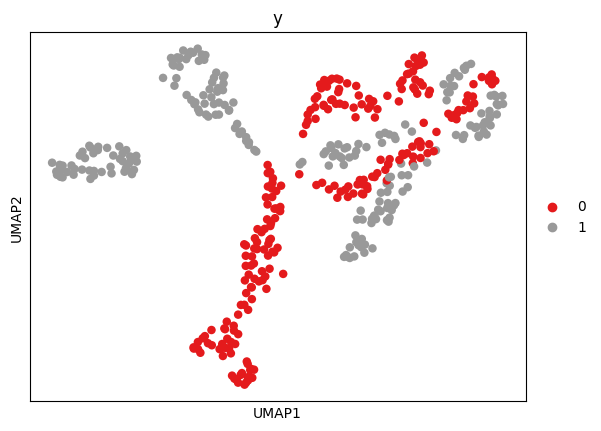

In [16]:
# Convert the 'y' column to the pandas 'category' dtype
adata.obs['y'] = adata.obs['y'].astype('category')
adata.obs['sample_id'] = adata.obs['sample_id'].astype('category')
# The plotting command will now work correctly
sc.pl.umap(adata, color='y', palette='Set1', s=150)

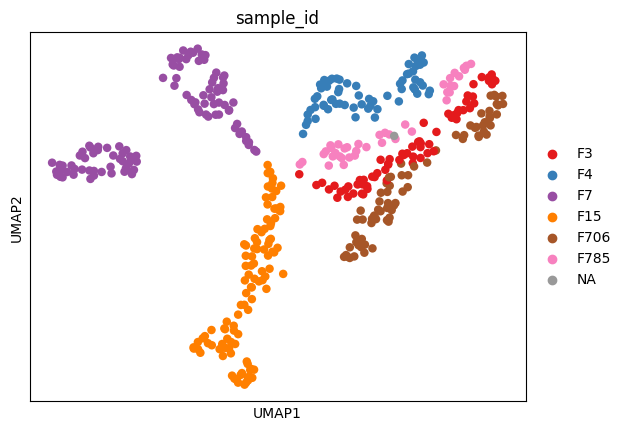

In [17]:
sc.pl.umap(adata, color='sample_id', palette='Set1', s=150)